# 신경망 학습

## 1 손실함수
손실함수는 신경망이 학습을 하는 지표로 MSE, cross-entropy 등이 있다.

### 1.1 MSE

In [1]:
import numpy as np

In [2]:
def mean_squred_error(y, t):
	return 0.5 * np.sum((y-t)**2)

In [3]:
t = [0, 0, 1, 0, 0]
y = [0.1, 0.05, 0.6, 0.05, 0.2]

print(mean_squred_error(np.array(y), np.array(t)))

0.10750000000000003


### 1.2 cross entropy error

In [4]:
def cross_entropy_error(y, t):
	delta = 1e-7
	return -np.sum(t * np.log(y + delta))

In [5]:
t = [0, 0, 1, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0, 0.1, 0.05, 0, 0.1]

print(cross_entropy_error(np.array(y), np.array(t)))

0.510825457099338


### 1.3 mini batch
배치 단위로 학습을 할 때는 모든 데이터에 대한 평균 손실 함수를 사용하면 이상적일 것이다.
하지만 데이터의 사이즈가 너무 커지면 이는 현실적이지 않다. 따라서 일부 데이터를 샘플링하여 샘플에 대한 손실 함수를 이용하여 학습한다. 이 샘플을 mini batch라고 부른다.
 

In [6]:
import sys, os
sys.path.append(os.curdir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [7]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)

x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [39]:
def cross_entropy_error_one_hot(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

다음은 정답이 one-hot encoding이 되어있지 않은 경우의 cross-entropy이다.

In [20]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

정확도가 아니라 손실 함수를 학습에 사용하는 이유는 정확도는 작은 변화에 반응이 거의 없어 미분 값이 0이기 때문이다.

## 2. 신경망 구현하기
### 2.1 편미분 구현

In [21]:
def ex_function(x):
    return x[0] ** 2 + x[1] ** 2

In [22]:
def ex_func_batch(x):
    return x[:, 0] ** 2 + x[:, 1] ** 2

In [23]:
ex_func_batch(np.array([[3.0, 4.0],
                        [4.0, 5.0],
                        [6.0, 7.0],
                        [6.0, 7.0]]))

array([25., 41., 85., 85.])

In [72]:
def _numerical_grad(f, x):
    h = 1e-4
    grad = np.zeros(x.size)

    for dim in range(x.size):
        temp = x[dim]

        x[dim] = temp - h
        f1 = f(x)

        x[dim] = temp + h
        f2 = f(x)

        grad[dim] = (f2 - f1) / (2 * h)

    return grad

# 데이터 하나씩 계산하니까 너무 느림
def numerical_gradient_batch(f, X):
    if X.ndim == 1:
        return _numerical_grad(f, X)

    grad = np.zeros_like(X)
    for idx in range(X.shape[0]):
        grad[idx] = _numerical_grad(f, X[idx])

    return grad

#not work
def numerical_gradient_batch_v2(f, X):
    h = 1e-4
    if X.ndim == 1:
        return _numerical_grad(f, X)

    grad = np.zeros_like(X)
    for col in range(X.shape[1]):
        H = np.zeros_like(X)
        H[:, col] += h

        f1 = f(X - H)
        f2 = f(X + H)

        grad[:, col] = (f2 - f1) / (2 * h)

    return grad

In [73]:
numerical_gradient_batch(ex_function, np.array([3.0, 4.0]))

array([6., 8.])

In [74]:
numerical_gradient_batch_v2(ex_func_batch, np.array([[3.0, 4.0],
                                                   [4.0, 5.0],
                                                   [6.0, 7.0],
                                                   [1.0, 4.0]]))

array([[ 6.,  8.],
       [ 8., 10.],
       [12., 14.],
       [ 2.,  8.]])

In [75]:
numerical_gradient_batch_v2(ex_function, np.array([3.0, 4.0]))

array([6., 8.])

In [76]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(a):
    c = np.max(a) # overflow 방지
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1 = self.params['W1']
        b1 = self.params['b1']
        W2 = self.params['W2']
        b2 = self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error_one_hot(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient_batch(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient_batch(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient_batch(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient_batch(loss_W, self.params['b2'])
        
        return grads

In [77]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [78]:
x = np.random.rand(100, 784)
y = net.predict(x)

In [80]:
x = np.random.rand(3, 784)
t = np.random.rand(3, 10)

grads = net.numerical_gradient(x, t)

grads['W1'].shape
grads['b1'].shape
grads['W2'].shape
grads['b2'].shape

(10,)

In [81]:
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [82]:
iters_num=10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

In [ ]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

train_loss_list = []
train_acc_list = []
test_acc_list = []

point_count = 0

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = net.numerical_gradient(x_batch, t_batch)
    
    print(grad['W1'])
    print(grad['W2'])
    net.params['W1'] -= learning_rate * grad['W1']
    net.params['b1'] -= learning_rate * grad['b1']
    net.params['W2'] -= learning_rate * grad['W2']
    net.params['b2'] -= learning_rate * grad['b2']
    
    loss = net.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % 10 == 0:
        point_count += 1
        
        train_acc = net.accuracy(x_train, t_train)
        test_acc = net.accuracy(x_test, t_test)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(f"{i}th iter... test_acc: {test_acc}, train_acc: {train_acc}, loss: {loss}")

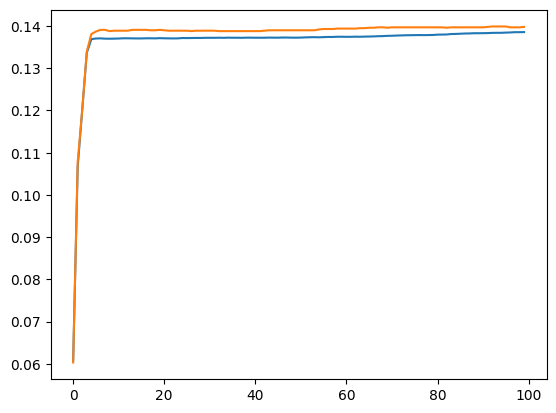

In [55]:
import matplotlib.pyplot as plt

plt.plot(np.arange(point_count), train_acc_list)
plt.plot(np.arange(point_count), test_acc_list)
plt.show()

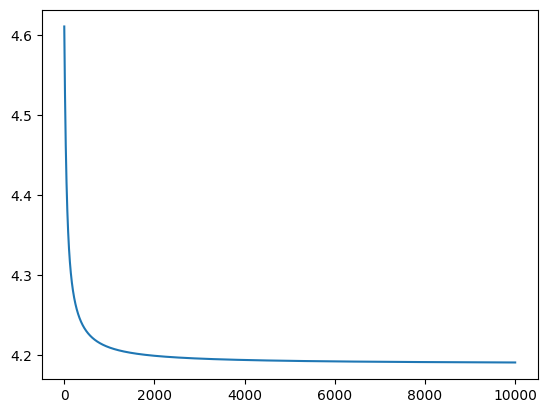

In [56]:
plt.plot(np.arange(iters_num), train_loss_list)
plt.show()